In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
subscription = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/19. subscription/subscription.csv')
subscription.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [3]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   user_id                    500000 non-null  int64 
 1   subscription_signup_date   500000 non-null  object
 2   subscription_monthly_cost  500000 non-null  int64 
 3   country                    500000 non-null  object
 4   source                     500000 non-null  object
 5   billing_cycles             500000 non-null  int64 
 6   is_active                  500000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 26.7+ MB


### Question 1
A model that predicts monthly retention rate for the different subscription price points.

In [4]:
cost_cycles = subscription[['user_id','subscription_monthly_cost','billing_cycles']].groupby(['subscription_monthly_cost','billing_cycles']).count().unstack(level=1)
cost_cycles

user_id                                         \
billing_cycles                  1      2      3      4     5     6     7   
subscription_monthly_cost                                                  
29                          57441  21818  12037   7787  5505  4136  3111   
49                         185145  53296  21690  11288  6727  4405  3173   
99                          44788   4724   1471    678   399   226   156   

                                  
billing_cycles                 8  
subscription_monthly_cost         
29                         34527  
49                         14673  
99                           799

In [5]:
# Perform a reverse cumsum to get the # of people by the end of each billing cycles
cost_cycles = cost_cycles.apply(lambda s: s.iloc[::-1].cumsum().iloc[::-1],axis=1).transpose()
cost_cycles = cost_cycles.reset_index().reset_index()
cost_cycles 

subscription_monthly_cost,index,level_0,billing_cycles,29,49,99
0,0,user_id,1,146362,300397,53241
1,1,user_id,2,88921,115252,8453
2,2,user_id,3,67103,61956,3729
3,3,user_id,4,55066,40266,2258
4,4,user_id,5,47279,28978,1580
5,5,user_id,6,41774,22251,1181
6,6,user_id,7,37638,17846,955
7,7,user_id,8,34527,14673,799


In [6]:
cost_cycles = cost_cycles.iloc[:, 2:]
cost_cycles

subscription_monthly_cost,billing_cycles,29,49,99
0,1,146362,300397,53241
1,2,88921,115252,8453
2,3,67103,61956,3729
3,4,55066,40266,2258
4,5,47279,28978,1580
5,6,41774,22251,1181
6,7,37638,17846,955
7,8,34527,14673,799


In [7]:
cost_cycles.columns

Index(['billing_cycles', 29, 49, 99], dtype='object', name='subscription_monthly_cost')

In [8]:
cost_cycles.set_index('billing_cycles', inplace=True)

In [9]:
cost_cycles

subscription_monthly_cost,29,49,99
billing_cycles,,,
1,146362,300397,53241
2,88921,115252,8453
3,67103,61956,3729
4,55066,40266,2258
5,47279,28978,1580
6,41774,22251,1181
7,37638,17846,955
8,34527,14673,799


<AxesSubplot:xlabel='billing_cycles'>

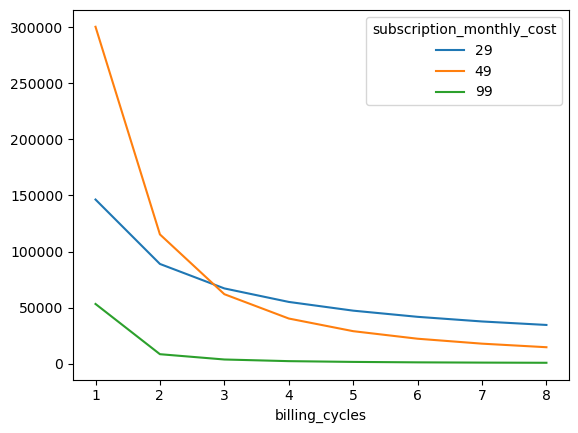

In [10]:
cost_cycles.plot()

### Fit Linear Regression model

From the plot above, we can draw following conclusions:

- For each 'monthly_cost', there are only 8 billing_cycles. Hence, complex model will overfit on small dataset, so we use a simple linear regression model. 

- The remaining # of subscribers by the end of each billing cycles has a nonlinear relationship with # of billing_cycles, so we need to include some nonlinear transformation of 'billing_cycles'.

- By no means, the target, # of subscribers should be non-negative. Hence, we use log(# of subscribers) at the end of each billing cycle', then after obtaining the fitted value, we transform back to '# of subscribers' by exp(), which can guarantee the result is always positive.

In [11]:
def make_time_features(t):
    """
    three features:
    1. t: #cycles
    2. t-square: square of #cycles
    3. logt: log(#cycles)
    """
    return pd.DataFrame({'t': t,'logt': np.log(t),'tsquare':t*t },index = t)

def fit_linear_regression(s):
    """
    target:
    log(s): s is #subscribers left by the end of each billing cycle
    do this transformation, to guarantee that, after tranforming back, the fitted result is always positive
    """
    X = make_time_features(s.index)
    return LinearRegression().fit(X,np.log(s))

In [12]:
lr_by_cost = cost_cycles.apply(fit_linear_regression,axis=0)

### Predict on billing cycles from 9~12 months

In [13]:
allt = np.arange(1,13)
Xwhole = make_time_features(allt)
Xwhole

,t,logt,tsquare
1,1,0.000000,1
2,2,0.693147,4
3,3,1.098612,9
4,4,1.386294,16
5,5,1.609438,25
6,6,1.791759,36
7,7,1.945910,49
8,8,2.079442,64
9,9,2.197225,81
10,10,2.302585,100


In [14]:
# call each cost's model to fit on above features
predicts = lr_by_cost.apply(lambda lr: pd.Series(lr.predict(Xwhole),index=allt)).transpose()
predicts = predicts.applymap(np.exp)

In [15]:
predicts

subscription_monthly_cost,29,49,99
1,146289.043583,301551.603773,52816.489536
2,89078.661927,113569.323151,8700.570325
3,67048.510837,62560.448086,3678.850952
4,54997.715283,40592.309531,2210.169591
5,47259.987332,28988.345871,1567.465186
6,41802.132010,22106.115832,1208.305347
7,37703.792361,17713.678002,968.806877
8,34484.309114,14771.777457,786.979952
9,31866.862280,12740.560957,636.784748
10,29680.233950,11317.105659,507.336931


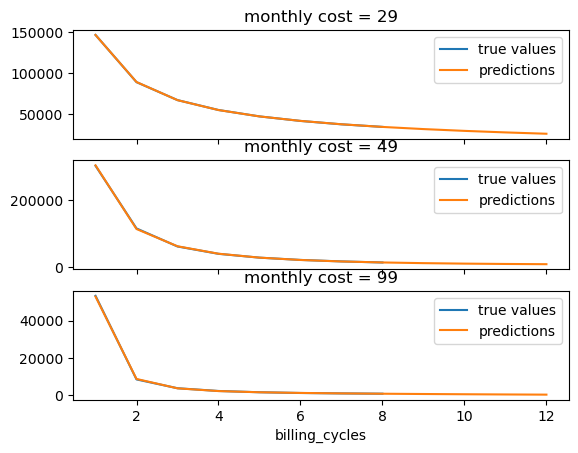

In [16]:
fig,axes = plt.subplots(3,1,sharex=True)
monthly_costs = [29,49,99]
for index,cost in enumerate(monthly_costs):
    ax = axes[index]
    cost_cycles.loc[:,cost].plot(ax = ax,label='true values')
    predicts.loc[:,cost].plot(ax=ax,label='predictions')
    ax.legend(loc='best')
    ax.set_title('monthly cost = {}'.format(cost))
plt.rc('figure',figsize=(5,10))

In [17]:
pd.merge(cost_cycles,predicts,how='right',left_index=True,right_index=True,suffixes = ('_true','_pred'))

subscription_monthly_cost,29_true,49_true,99_true,29_pred,49_pred,99_pred
1,146362.0,300397.0,53241.0,146289.043583,301551.603773,52816.489536
2,88921.0,115252.0,8453.0,89078.661927,113569.323151,8700.570325
3,67103.0,61956.0,3729.0,67048.510837,62560.448086,3678.850952
4,55066.0,40266.0,2258.0,54997.715283,40592.309531,2210.169591
5,47279.0,28978.0,1580.0,47259.987332,28988.345871,1567.465186
6,41774.0,22251.0,1181.0,41802.132010,22106.115832,1208.305347
7,37638.0,17846.0,955.0,37703.792361,17713.678002,968.806877
8,34527.0,14673.0,799.0,34484.309114,14771.777457,786.979952
9,NaN,NaN,NaN,31866.862280,12740.560957,636.784748
10,NaN,NaN,NaN,29680.233950,11317.105659,507.336931


### Question 2

Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

In [18]:
predicts.loc[12,:]/predicts.loc[1,:]

subscription_monthly_cost
29    0.179014
49    0.031984
99    0.005644
dtype: float64

### Question 3

How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

In [19]:
def calc_retention_rate(s):
    """
    input: 
        s: n-th value is #subscribers who paid 'n' cycles
    return:
        retention rate by the end of each cycle
    """
    r = s.iloc[::-1].cumsum().iloc[::-1]
    return r/r.iloc[0]

def retention_rate_by(colname):
    """
    step 1. group subscribers based on certain column, e.g., country or source
    step 2. for each group, count #subscribers who paid 'n' cycles
    step 3. for each group, calculate retention rate for each cycle
    """
    counts = subscription.groupby(colname).apply(lambda df: df.billing_cycles.value_counts()).unstack()
    return counts.apply(calc_retention_rate, axis=1).transpose()

In [20]:
retention_rate_by_country = retention_rate_by('country')
retention_rate_by_country

country,China,France,Germany,India,Italy,Spain,UK,US
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.514831,0.334946,0.451284,0.446728,0.341684,0.339098,0.458938,0.456509
3,0.402777,0.177732,0.278411,0.326962,0.179502,0.178985,0.285133,0.284255
4,0.360426,0.119004,0.195910,0.284527,0.119914,0.119879,0.198067,0.198853
5,0.336274,0.088479,0.146474,0.261603,0.090015,0.088648,0.149421,0.149284
6,0.319856,0.069935,0.115151,0.246736,0.071135,0.070065,0.117356,0.117398
7,0.307084,0.058341,0.093868,0.234847,0.057523,0.057617,0.095735,0.094875
8,0.295453,0.049688,0.078465,0.225769,0.048695,0.048503,0.079494,0.078981


<AxesSubplot:>

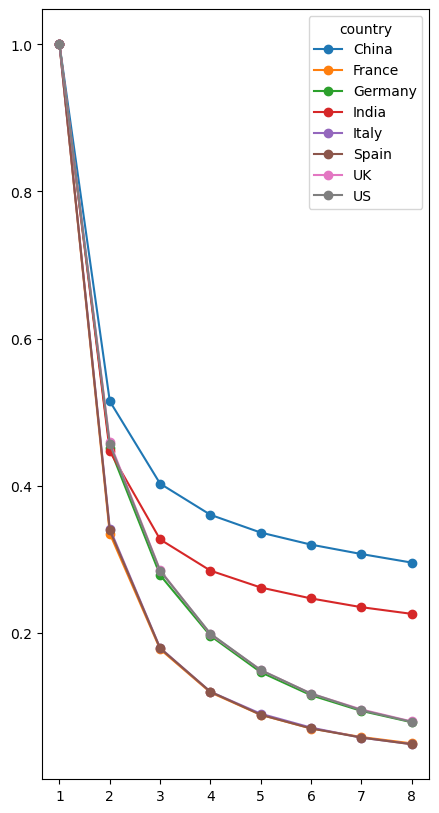

In [21]:
retention_rate_by_country.plot(marker='o')

In [22]:
# rank countries by August's retention rate
retention_rate_by_country.iloc[-1,:].sort_values(ascending=False)

country
China      0.295453
India      0.225769
UK         0.079494
US         0.078981
Germany    0.078465
France     0.049688
Italy      0.048695
Spain      0.048503
Name: 8, dtype: float64

Based on the result above, we can divide coutries into 3 classes:

1. Customers from China and Indian are the most loyal ones. 
   
   Not only retention rate is high, but also the 'dropping rate' is the slowest. 
   To increase the revenue, we should keep tight touch to customers in China and Indian. For examples, sending coupons to them from time to time.


2. UK, US, Germany have medium 'retention rate'


3. France, Italy, Spain has the lowest 'retention rate'
   We may consider to lower the 'monthly cost' in these countries, to keep more customers in subscription.

In [23]:
retention_rate_by_source = retention_rate_by('source')
retention_rate_by_source

source,ads,friend_referral,seo
1,1.000000,1.000000,1.000000
2,0.388873,0.699443,0.562395
3,0.222094,0.617038,0.420012
4,0.152607,0.561282,0.337594
5,0.114959,0.519854,0.286254
6,0.092043,0.487596,0.247877
7,0.076756,0.461110,0.218680
8,0.066237,0.436507,0.194475


<AxesSubplot:>

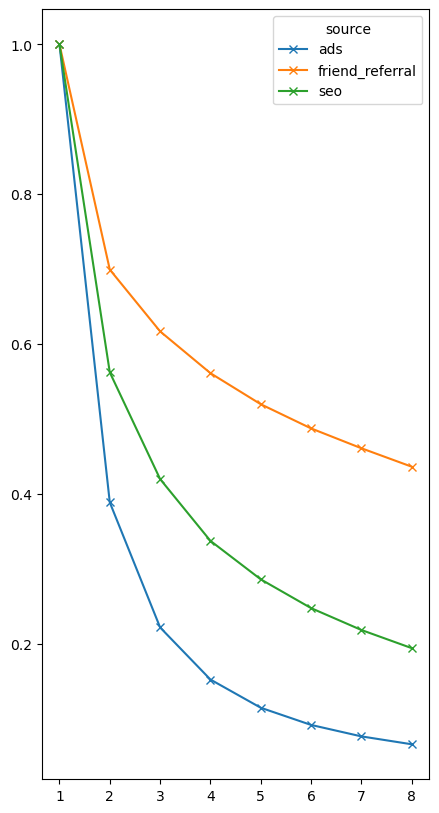

In [24]:
retention_rate_by_source.plot(marker='x')

From the result above, we can see that subscribers from 'friend_referral' are the most loyal.


To improve the revenue, we can launch some program to improve 'user referral'. For example, current subscribers can invite new users to subscribe. If your friends subscribe, you get rewarded with a certain amount of money or credit.